In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import os
import time

from tensorflow_examples.models.pix2pix import pix2pix

In [2]:
people = tf.data.Dataset.list_files('C:/Users/anang/OneDrive/Desktop/YNR/coffee shop/*', shuffle=False)
no_people = tf.data.Dataset.list_files('C:/Users/anang/OneDrive/Desktop/YNR/empty coffee shop/*', shuffle=False)

In [3]:
# train_horses, train_zebras = dataset['trainA'], dataset['trainB']
# test_horses, test_zebras = dataset['testA'], dataset['testB']

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
def random_crop(image):
  image = tf.image.random_crop(image, [IMG_WIDTH, IMG_HEIGHT, 3])

  return image

In [6]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = image/255

  return image

In [7]:
def random_jitter(image):
    print(tf.shape(image))
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    image = random_crop(image)
    
    image = tf.image.random_flip_left_right(image)
    
    return image

In [8]:
def load_and_preprocess_image(image_file):
    # Load the image from the file path
    image = tf.io.read_file(image_file)
    # Decode the image (e.g., JPEG or PNG)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to your desired dimensions
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    # Normalize pixel values (optional)
    image = (image / 127.5) - 1

    image = random_crop(image)
    
    image = tf.image.random_flip_left_right(image)
    return image

In [9]:
people = people.map(load_and_preprocess_image).batch(BATCH_SIZE)
no_people = no_people.map(load_and_preprocess_image).batch(BATCH_SIZE)

# test_horses = test_horses.map(preprocess_image).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# test_zebras = test_zebras.map(preprocess_image).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
sample_people = next(iter(people))
sample_no_people = next(iter(no_people))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


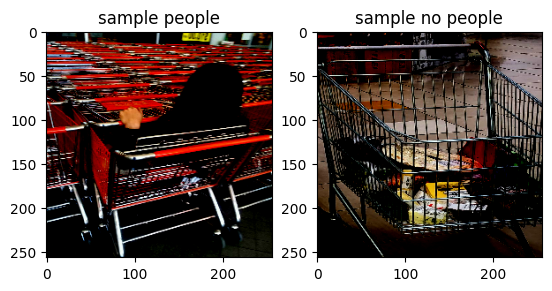

In [11]:
plt.subplot(121)
plt.title('sample people')
plt.imshow(sample_people[0])

plt.subplot(122)
plt.title('sample no people')
plt.imshow(sample_no_people[0])

In [12]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


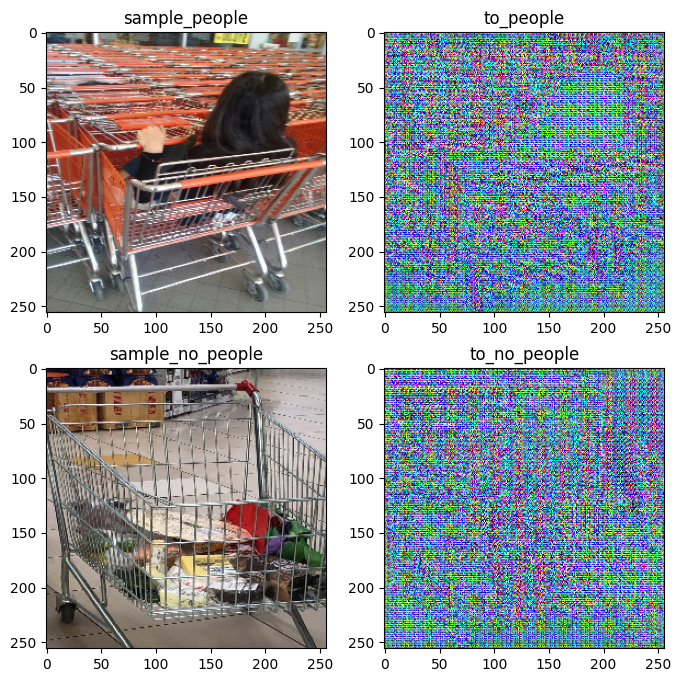

In [13]:
to_no_people = generator_g(sample_no_people)
to_people = generator_g(sample_people)

plt.figure(figsize=(8, 8))
contrast = 8

img = [sample_people, to_people, sample_no_people, to_no_people]
title = ['sample_people', 'to_people', 'sample_no_people', 'to_no_people']

for i in range(len(img)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(img[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(img[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [14]:
LAMBDA = 10

losses = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real, fake):
  real_loss = losses(tf.ones_like(real), real)
  fake_loss = losses(tf.zeros_like(fake), fake)

  total_loss = real_loss + fake_loss

  return total_loss * 0.5

In [16]:
def generator_loss(real):
  return losses(tf.ones_like(real), real) 

In [17]:
def calc_cycle_loss(real_image, cycled_image):
  loss = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss

In [18]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))

  return loss * LAMBDA * 0.5

In [19]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [20]:
def generate_images(model, test_image):
  prediction = model(test_image)

  plt.figure(figsize=(12, 12))

  display_list = [test_image[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [21]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [22]:
EPOCHS = 100

In [23]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [24]:
data = tf.data.Dataset.zip((people, no_people))

In [25]:
print(len(data))


404


In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((people, no_people)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1


  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_people)

  # if (epoch + 1) % 5 == 0:
  #   ckpt_save_path = ckpt_manager.save()
  #   print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
  #                                                        ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
for epoch in range(50):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((people, no_people)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1


  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_people)

  # if (epoch + 1) % 5 == 0:
  #   ckpt_save_path = ckpt_manager.save()
  #   print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
  #                                                        ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
image = load_and_preprocess_image('C:/Users/anang/OneDrive/Desktop/YNR/coffee shop stop ☕️.JPG')


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
img = os.path.join('Woman at cafe.JPG')

#load the image into a processible formable
image = load_img(img, target_size=(256, 256))

#convert the image into an array
image = img_to_array(image)

#reshape the array to match the input shape of the vgg16 model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

image = (image / 127.5) -1


In [ ]:
generate_images(generator_g, image)

In [ ]:
#load the image into a processible formable
# image = load_img(new_image, target_size=(256, 256))
print(tf.shape(new_image))
#convert the image into an array
image = img_to_array(new_image)


#reshape the array to match the input shape of the vgg16 model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

image = image/255
generate_images(generator_f, image)